<a href="https://colab.research.google.com/github/andxeg/MPI_Program_Execution_Time_Prediction/blob/master/embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPI programs execution time prediction using matrix decomposition algorithm

This notebook introduce MPI programs execution time prediction algorithm base on the matrix decomposition in particular Alternating Least Square algorithm.

Algorithm predicts MPI program execution time on the certain set of computer installation. Computer installation is high-performance computing cluster, data center or supercomputer.

We use data from *spec.org*: MPI benchmarks [https://spec.org/mpi2007/results/mpi2007.html].

Data is constantly updated, so we add it to our repository too.

## Prerequisites
- Download dataset
- Create some directories
- Install necessary packages

In [ ]:
! git clone https://github.com/andxeg/MoNeTec_2020_Embeddings.git

Cloning into 'MoNeTec_2020_Embeddings'...
remote: Enumerating objects: 1740, done.
remote: Counting objects: 100% (1740/1740), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 1740 (delta 1439), reused 1740 (delta 1439), pack-reused 0
Receiving objects: 100% (1740/1740), 2.66 MiB | 9.83 MiB/s, done.
Resolving deltas: 100% (1439/1439), done.


In [ ]:
!ls -la

total 20
drwxr-xr-x 1 root root 4096 Nov  7 23:23 .
drwxr-xr-x 1 root root 4096 Nov  7 23:22 ..
drwxr-xr-x 4 root root 4096 Nov  1 13:34 .config
drwxr-xr-x 5 root root 4096 Nov  7 23:23 MoNeTec_2020_Embeddings
drwxr-xr-x 1 root root 4096 Nov  1 13:35 sample_data


In [ ]:
%cd ./MoNeTec_2020_Embeddings/data/benchmarks

/content/MoNeTec_2020_Embeddings/data/benchmarks


In [ ]:
!ls -la

total 88
drwxr-xr-x 6 root root  4096 Nov  7 23:23 .
drwxr-xr-x 3 root root  4096 Nov  7 23:23 ..
drwxr-xr-x 2 root root 20480 Nov  7 23:23 meta_mpi
drwxr-xr-x 2 root root 36864 Nov  7 23:23 mpi_logs
drwxr-xr-x 2 root root  4096 Nov  7 23:23 preprocessed
drwxr-xr-x 2 root root 20480 Nov  7 23:23 preprocessed_mpi


In [ ]:
!mkdir ./preprocessed_mpi/
!mkdir ./meta_mpi/

mkdir: cannot create directory ‘./preprocessed_mpi/’: File exists
mkdir: cannot create directory ‘./meta_mpi/’: File exists


In [ ]:
!rm ./preprocessed_mpi/*
!pwd

/content/MoNeTec_2020_Embeddings/data/benchmarks


In [ ]:
!python --version

Python 3.7.12


In [ ]:
!pip install pandas numpy matplotlib scikit-learn scipy tqdm

## Short introduction

The pipeline is as follows:
- Read data with MPI and OpenMP executions on different computer installation. Each entry in input data is considered as a separate computer installation. Extract execution time for each program on each computer installation;
- Create *PC* matrix (*PC* -- Program-Computer) -- matrix where rows correspond to history of running of programs, columns correspond to the computer installations. In our case one program corresponds to one row in the PC matrix. But you can create *PC* matrix where one program corresponds multiple rows;
- Make prediction using Ridge Regression (as baseline) and ALS algorithm.

## Parse csv with results of programs execution 

In [ ]:
import glob
import random
import numpy as np
import pandas as pd

# Read data with MPI benchmarks executions on the different computer installation
for j, i in enumerate(glob.glob('./mpi_logs/*.csv')):
    print(i)
    accel = open(i,'r').readlines()
    f=open('./preprocessed_mpi/'+str(j) + ".csv", 'w')
    f.write("".join(accel[accel.index('"Selected Results Table"\n')+2:accel.index('"Selected Results Table"\n')+16]))
    f.close()
    f=open('./meta_mpi/'+str(j)+".csv", 'w')
    try:
        #f.write("".join(accel[accel.index('HARDWARE\n'):accel.index('"General Notes"\n')]))
        f.write("".join(accel[accel.index('HARDWARE\n'):accel.index('"Node Description: NFS"\n')]))
    except:
        f.write("".join(accel[accel.index('HARDWARE\n'):]))
    f.close()

logs =[]
for i in glob.glob('./preprocessed_mpi/*'):
    logs.append(pd.read_csv(i))

./mpi_logs/mpi2007-20150526-00493.csv
./mpi_logs/mpi2007-20080702-00052.csv
./mpi_logs/mpi2007-20120221-00353.csv
./mpi_logs/mpi2007-20081225-00088.csv
./mpi_logs/mpi2007-20090428-00139.csv
./mpi_logs/mpi2007-20110304-00257.csv
./mpi_logs/mpi2007-20120221-00351.csv
./mpi_logs/mpi2007-20080702-00053.csv
./mpi_logs/mpi2007-20081203-00084.csv
./mpi_logs/mpi2007-20120207-00346.csv
./mpi_logs/mpi2007-20140106-00425.csv
./mpi_logs/mpi2007-20070614-00025.csv
./mpi_logs/mpi2007-20130820-00398.csv
./mpi_logs/mpi2007-20090302-00095.csv
./mpi_logs/mpi2007-20190312-00616.csv
./mpi_logs/mpi2007-20090922-00177.csv
./mpi_logs/mpi2007-20071013-00030.csv
./mpi_logs/mpi2007-20100921-00246.csv
./mpi_logs/mpi2007-20140218-00444.csv
./mpi_logs/mpi2007-20140902-00473.csv
./mpi_logs/mpi2007-20070525-00001.csv
./mpi_logs/mpi2007-20100223-00207.csv
./mpi_logs/mpi2007-20160727-00518.csv
./mpi_logs/mpi2007-20120221-00370.csv
./mpi_logs/mpi2007-20090728-00172.csv
./mpi_logs/mpi2007-20171011-00585.csv
./mpi_logs/m

## Prepare data for PC matrix creation

In [ ]:
computers={}
for j,i in enumerate(logs):
    if i['Base Run Time'].iloc[0] =='NC':
        continue
    computers[j]={'Run Time': i['Base Run Time']}
    if i['Benchmark'].iloc[0] == '121.pop2':
        computers[j]['class'] = 1
    else:
        computers[j]['class'] = 2
    #computers[j]=i['Base Ratio']

class_1 = {}
class_2 = {}
for item in computers.items():
    if item[1]['class'] == 1:
        class_1[item[0]]=item[1]['Run Time']
    else:
        if np.isnan(item[1]['Run Time']).any():
            continue
        class_2[item[0]]=item[1]['Run Time']

## Create *PC* matrix

In [ ]:
df = pd.DataFrame.from_records(class_2)

In [ ]:
df

,1,2,3,4,5,6,8,9,10,11,15,16,17,18,19,21,22,24,26,27,28,29,30,31,32,34,35,36,37,38,39,41,42,43,45,46,48,49,50,51,...,526,528,529,530,531,532,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,550,552,555,557,558,559,560,564,566,567,568,570,573,574,575,577,578,579,580
0,15.364740,207.7,700.660535,33.320302,65.874527,47.433990,94.815893,6.988289,317.401075,473.320781,183.261600,55.090541,47.776947,291.696447,33.820130,125.554151,42.039596,19.857905,86.004027,56.281590,31.705661,20.551419,32.288509,270.323651,179.863763,142.577624,83.041239,355.838718,163.840630,153.539363,426.213185,97.545377,162.953176,127.378413,105.805730,53.775434,100.901167,62.517829,43.354320,112.157310,...,386.324542,107.867020,24.249903,49.369338,50.597294,61.067794,103.670506,586.123365,359.884975,211.396205,12.167641,54.563188,200.244916,648.762047,189.421439,191.292796,15.870054,316.205252,67.804184,389.129703,453.238996,439.303455,72.486488,433.852518,24.293740,23.738117,55.281823,406.537755,34.554959,222.336642,54.072404,126.370101,101.957246,47.464406,90.617188,126.921722,1549.904813,508.037446,152.659348,151.970232
1,41.757358,740.7,2519.218538,126.375770,160.306838,140.629037,272.437986,21.086055,842.326298,1655.736209,483.128371,138.776409,131.610235,659.615110,73.988350,439.522958,105.900880,61.248167,219.097651,194.787491,125.970215,78.573564,126.780797,652.708534,477.922814,454.811507,351.141263,1202.395421,533.190913,369.222218,1498.182114,322.982538,516.585431,318.096433,384.592714,191.010457,340.735778,223.152957,106.330852,408.392469,...,990.164237,437.686694,58.704114,119.634791,144.284826,193.185014,381.166608,1668.094235,1411.493003,769.580034,38.952680,125.274629,520.420449,1810.903544,666.074425,508.786054,53.844638,893.138208,273.060829,1224.882981,1030.675054,1042.733189,180.051571,1522.947676,66.825617,56.900651,145.382601,1049.322888,91.333531,765.431638,202.218945,371.258963,271.151819,119.751074,248.820814,365.427017,5230.784191,1328.476288,507.466854,394.906397
2,249.716353,507.6,2063.012665,271.456838,148.874870,324.932551,217.104949,169.497890,775.281699,1416.842258,374.541888,321.825367,212.732709,594.704711,316.467433,339.848322,165.226648,273.809992,227.507224,244.526049,197.341883,346.043410,281.589520,557.858636,365.423551,335.619525,886.384872,956.255742,407.715104,304.379609,1159.142589,237.616333,377.795449,297.865062,276.803203,242.124124,246.975479,195.228010,279.990239,290.122638,...,738.476124,294.355766,187.532850,147.481406,478.129575,165.650769,270.100894,1091.926974,938.908886,562.043451,324.954430,141.489873,395.852049,1677.586840,466.335012,389.597138,358.527337,712.515293,639.902562,868.984454,815.527933,1580.437325,157.083978,1238.947989,308.463069,201.127791,532.294270,836.724717,149.772383,532.704041,188.689887,295.028181,389.878879,140.285307,203.532208,279.033136,6568.863362,1077.158206,371.638385,355.062588
3,19.469998,300.9,881.593303,33.026178,80.046037,63.036408,107.798620,13.770920,277.150143,656.979511,197.314045,66.322830,39.504504,221.496130,59.009974,190.080994,36.363687,19.864782,104.339302,63.040485,24.305793,17.198605,31.509672,299.822874,183.400123,162.636802,86.328366,370.753902,192.456676,167.763592,570.159751,141.425349,202.842596,170.794644,159.649388,59.961335,145.397277,102.285772,26.050389,175.675864,...,451.743756,167.306224,29.246298,56.916712,51.164390,69.647977,160.809606,710.334040,642.039853,315.247693,12.253796,45.606429,218.962454,1059.750783,232.104074,197.998879,15.101063,375.553646,34.125497,463.667555,446.357647,398.976396,74.879310,586.824982,20.526460,54.413640,81.141503,439.603684,28.606430,311.443932,88.660586,157.731487,79.523853,48.972629,101.320277,141.784394,1994.095434,549.992459,218.877966,212.187807
4,181.022050,509.5,1295.957962,190.094130,219.379912,173.760583,330.904450,65.038169,486.891881,988.953733,326.031305,171.005751,179.983597,544.402442,121.254296,354.030349,111.666979,180.191049,135.283146,222.914279,259.375144,155.609302,238.558964,503.7

## Matrix decomposition with ALS algorithm

In [ ]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [20, 10]
def runALS(A, R, n_factors, n_iterations, lambda_):
    n, m = A.shape
    W = 3 * np.random.rand(n, n_factors)
    H = 3 * np.random.rand(n_factors, m)
    A_copy = A
    A = A*R
#     def get_error(A, W, H, R):
#         return ((np.invert(R) * np.abs(A_copy - np.dot(W, H))) / A_copy)# / np.sum(np.invert(R))

    def get_error(A, W, H, R):
        return np.sum((np.invert(R) * np.abs(A_copy - np.dot(W, H))) / A_copy) /np.sum(np.invert(R))
    
    MSE_List = []
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            W[i] = np.linalg.solve(np.dot(H, np.dot(np.diag(Ri), H.T)) + lambda_ * np.eye(n_factors),
                                       np.dot(H, np.dot(np.diag(Ri), A[i].T))).T
        #print("Error after solving for W Matrix:", get_error(A, W, H, R))

        for j, Rj in enumerate(R.T):
            H[:,j] = np.linalg.solve(np.dot(W.T, np.dot(np.diag(Rj), W)) + lambda_ * np.eye(n_factors),
                                     np.dot(W.T, np.dot(np.diag(Rj), A[:, j])))
        #print("Error after solving for H Matrix:", get_error(A, W, H, R))

        MSE_List.append(get_error(A, W, H, R))
        #print(f'{iter}th iteration is complete...')

    #print(MSE_List)
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(range(1, len(MSE_List) + 1), MSE_List)
    plt.ylabel('Error')
    plt.xlabel('Iteration')
    plt.show()
    '''
    return W, H, MSE_List[-1]

In [ ]:
# Function for zeroing a random entry of PC matrix
def nul_2(df_2, cells, i=-1, j = -1):
    
    if i<0:
        i = random.choice(range(df_2.shape[0]))
    if j<0:
        j = random.choice(range(df_2.shape[1]))
    
    df_2[i, j] = 0
    return df_2, i, j 

## Test ALS decomposition

In [ ]:
A = df.to_numpy()
R = np.invert(np.zeros(A.shape, dtype=np.bool))
cells =[]
for i in range(2000):
    R,k,l = nul_2(R, cells)
W,H,loss = runALS(A,R, n_factors=1, n_iterations=2, lambda_=0.3)

In [ ]:
R

array([[ True,  True, False, ...,  True,  True,  True],
       [ True,  True,  True, ..., False,  True,  True],
       [False,  True,  True, ...,  True, False,  True],
       ...,
       [False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ..., False, False, False]])

In [ ]:
np.sum(np.invert(R))/A.shape[0]/A.shape[1]

0.32245532245532244

In [ ]:
W,H,loss = runALS(A,R, n_factors=1, n_iterations=2, lambda_=0.3)
W, H, loss

(array([[121.98447313],
        [343.60595828],
        [276.13426831],
        [137.40530034],
        [179.55239701],
        [182.69527507],
        [192.73354099],
        [282.73624395],
        [119.34929655],
        [155.20493888],
        [210.15959107],
        [173.01879777],
        [284.05598711]]),
 array([[ 0.25484576,  2.2206236 ,  7.52367047,  0.4233631 ,  0.54585999,
          0.50558505,  0.80509685,  0.17707968,  2.57579696,  5.25363288,
          1.43009228,  0.57028296,  0.48769295,  1.7538451 ,  0.4604849 ,
          1.37100876,  0.33085104,  0.68175011,  0.60568861,  0.62531604,
          0.44901653,  0.32674522,  0.44536747,  2.30428589,  1.35883391,
          1.0058399 ,  0.90706991,  3.5397076 ,  1.47348187,  1.15457528,
          4.21741682,  0.92626921,  1.5133005 ,  0.90963409,  1.23310512,
          0.52976424,  1.02378632,  0.68255016,  0.4324845 ,  1.24652471,
          2.32395122,  3.6107586 ,  0.5165424 ,  0.61510533,  0.14124433,
          0.74936923

## Some useful functions

In [ ]:
def gen_X(df_2, cell):
    train = []
    df_np = df_2
    for i in range(df.shape[0]):
        if i != cell[0]:
            train.append(np.concatenate([df_np[i][:cell[1]], df_np[i][cell[1]+1:]]))
    return np.array(train)
    
def gen_Y(df_2, cell): 
    df_np = df_2
    return np.concatenate([df_np[:cell[0],cell[1]], df_np[cell[0]+1:,cell[1]]])
    
    
def gen_predict(df_2, cell):
    df_np = df_2
    return [np.concatenate([df_np[cell[0]][:cell[1]], df_np[cell[0]][cell[1]+1:]])]

## Make prediction using Ridge Regression and ALS decomposition with K=1,2,3,4

In [ ]:
from tqdm import tqdm
from sklearn.linear_model import Ridge

A = df.to_numpy()
l_ = []
l__ =[]
points = range(1,400,5)
for point in tqdm(points):
    losses=[]
    ridge_losses =[]
    R = np.invert(np.zeros(A.shape, dtype=np.bool))    
    cells = []
    point = int(A.shape[0]*A.shape[1]*point/100)
    for i in range(point):
        R,k,l = nul_2(R, cells)
        cells.append((k,l))
    df_np = A*R
    diff=[]
    for cell in cells:
        z = Ridge()

        z.fit(gen_X(df_np, cell), gen_Y(df_np, cell))
        y = z.predict(gen_predict(df_np, cell))
        diff.append(np.abs(y - A[cell[0],cell[1]]) / A[cell[0],cell[1]])
    ridge_losses.append(np.mean(diff))
    for n_factors in range(1,5):   
        W_, H_, loss = runALS(A, R, n_factors = n_factors, n_iterations = 2, lambda_ = .3)
        losses.append(loss)
    l_.append([np.sum(100*np.invert(R))/(A.shape[0]*A.shape[1]), losses,ridge_losses])

 24%|██▍       | 19/80 [00:51<04:32,  4.47s/it]

## Prediction error for algorithms

In [ ]:
ALS_losses = [[] for i in range(4)]
percents = []
ridge_losses = []
for i,k in enumerate(points):
    for j in range(4):
        ALS_losses[j].append(l_[i][1][j])
    percents.append(l_[i][0])
    ridge_losses.append(l_[i][2])

    
ALS_1_loss = list(map(np.mean, ALS_losses[0]))
ALS_2_loss = list(map(np.mean, ALS_losses[1]))
ALS_3_loss = list(map(np.mean, ALS_losses[2]))
ALS_4_loss = list(map(np.mean, ALS_losses[3]))
for i, e in enumerate(percents):
    p = int(e * 100) / 100.0
    print("%5d%% | ALS_1: %10f | ALS_2: %10f | ALS_3: %10f | ALS_4: %10f" % (p, ALS_1_loss[i], ALS_2_loss[i], ALS_3_loss[i], ALS_4_loss[i]))

    0% | ALS_1:   0.304770 | ALS_2:   0.291317 | ALS_3:   0.256885 | ALS_4:   0.186766
    5% | ALS_1:   0.371356 | ALS_2:   0.263561 | ALS_3:   0.233956 | ALS_4:   0.415136
   10% | ALS_1:   0.393319 | ALS_2:   0.389424 | ALS_3:   0.420391 | ALS_4:   0.402494
   14% | ALS_1:   0.399947 | ALS_2:   0.441917 | ALS_3:   0.365575 | ALS_4:   0.426646
   19% | ALS_1:   0.419366 | ALS_2:   0.379676 | ALS_3:   0.427229 | ALS_4:   0.415509
   22% | ALS_1:   0.401160 | ALS_2:   0.419548 | ALS_3:   0.373966 | ALS_4:   0.518120
   26% | ALS_1:   0.409413 | ALS_2:   0.425281 | ALS_3:   0.473120 | ALS_4:   0.530076
   30% | ALS_1:   0.423226 | ALS_2:   0.451358 | ALS_3:   0.562557 | ALS_4:   0.572342
   34% | ALS_1:   0.412967 | ALS_2:   0.444355 | ALS_3:   0.509558 | ALS_4:   0.465167
   36% | ALS_1:   0.389346 | ALS_2:   0.412874 | ALS_3:   0.606487 | ALS_4:   0.697950
   40% | ALS_1:   0.404769 | ALS_2:   0.432277 | ALS_3:   0.666683 | ALS_4:   0.692930
   43% | ALS_1:   0.476762 | ALS_2:   0.491

## Graphics

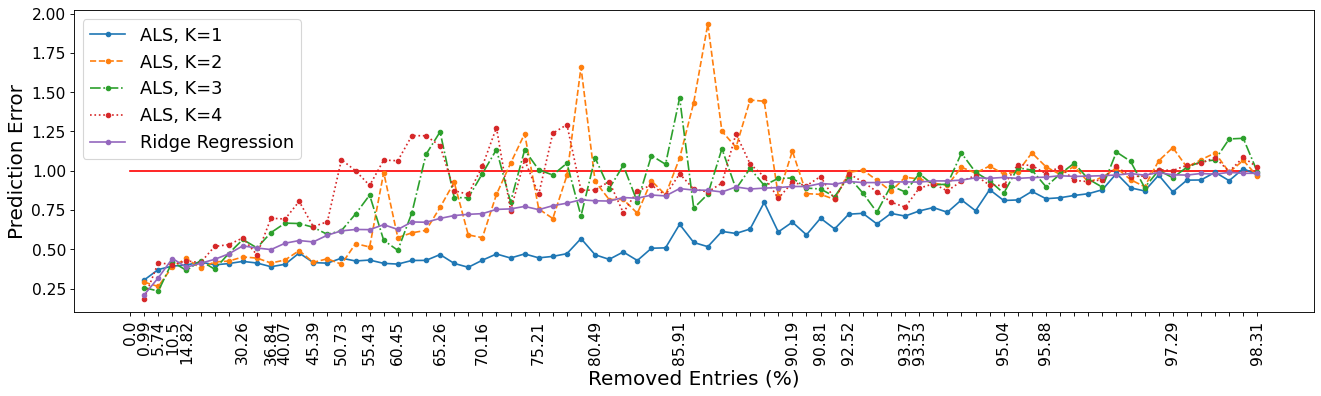

In [ ]:
import math

fig = plt.figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

plt.plot(range(0, len(ridge_losses) + 1), [1 for i in range(0, len(ridge_losses) + 1)], color="red")

plt.plot(range(1, len(ridge_losses) + 1), list(map(np.mean, ALS_losses[0])), linestyle='-', marker='o', markersize=4, label='ALS, K=1')
plt.plot(range(1, len(ridge_losses) + 1), list(map(np.mean, ALS_losses[1])), linestyle='--', marker='o', markersize=4, label='ALS, K=2')
plt.plot(range(1, len(ridge_losses) + 1), list(map(np.mean, ALS_losses[2])), linestyle='-.', marker='o', markersize=4, label='ALS, K=3')
plt.plot(range(1, len(ridge_losses) + 1), list(map(np.mean, ALS_losses[3])), linestyle=':', marker='o', markersize=4, label='ALS, K=4')
plt.plot(range(1, len(ridge_losses) + 1), ridge_losses, marker='o', linestyle='-', markersize=4, label='Ridge Regression')

# Custom ticks, miss some values
# xticks = [math.ceil(p) for p in percents]
xticks = [int(p * 100) / 100.0 for p in percents]

# Leave 1%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90-98%
miss_index = set(range(0, 80)) - set([0, 1, 2, 3, 7, 9, 10, 12, 14, 16, 18, 21, 24, 28, 32, 38, 46, 48, 50, 54, 55, 61, 64, 73, 79])
for i in miss_index:
    xticks[i] = None

xticks.insert(0, 0.0)

plt.xticks(range(0,len(points)+1), xticks, rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.legend(prop={"size": 16})
# plt.title('Dependence of the prediction error on the percentage of removed matrix entries', fontsize=20)
plt.ylabel('Prediction Error', fontsize=18)
plt.xlabel('Removed Entries (%)', fontsize=18)
plt.show()

In [ ]:
# PC matrix rank
np.linalg.matrix_rank(W*H, tol=0.01)

1